<h1 id="Train-on-Google-Cloud-ML-Engine">Train, deploy, predict on Google Cloud ML Engine</h1>

<p>tags: kaggle, digit, mnist, cnn, esitmator, google cloud, ml-engline, ai-platform, submit, train&nbsp;&nbsp;</p>

<p>read this doc to start off&nbsp;</p>

<p><a href="https://cloud.google.com/ml-engine/docs/tensorflow/getting-started-training-prediction#tensorboard-local" target="_blank">https://cloud.google.com/ml-engine/docs/tensorflow/getting-started-training-prediction#tensorboard-local</a></p>

<h2 id="modification-from-local-run">modification from local run</h2>

<ol>
	<li>import gcsfs in this notebook</li>
	<li>put &#39;gcsfs&#39;&nbsp;in REQUIRED_PACKAGE in setup.py</li>
	<li>change &#39;export&#39; directory name to just the name no &#39;/\&#39;</li>
</ol>

<h2 id="Recommended-project-structure">Recommended project structure</h2>

<p><img src="recommended-project-structure.png" /></p>


<h2 id="to-do-list-before-submit-the-job">to-do list before submit the job</h2>

<ol>
	<li>get or set project id from gcp console</li>
	<li>create a bucket and folders, then upload training data</li>
</ol>




In [1]:
import os
import shutil
from datetime import datetime
import gcsfs
from tensorflow.keras.callbacks import TensorBoard
import json, codecs
import matplotlib.pyplot as plt
import pandas as pd

PROJECT = "_____" # REPLACE WITH YOUR PROJECT ID
BUCKET = "_____" # REPLACE WITH YOUR BUCKET NAME
REGION = "us-central1" # REPLACE WITH YOUR BUCKET REGION e.g. us-central1
TFVERSION = "1.13"


In [2]:
# Do not change these
os.environ["PROJECT"] = PROJECT
os.environ["BUCKET"] = BUCKET
os.environ["REGION"] = REGION
os.environ["TFVERSION"] = TFVERSION  # Tensorflow version

In [ ]:
!gcloud auth list
!gcloud config set project $PROJECT
!gcloud config set compute/region $REGION
!gcloud config list project
#!gcloud compute instances list

<h2 id="Train-locally">Train locally (for testing)</h2>


In [4]:
OUTDIR='trained_test'
INPDIR='..\data'
shutil.rmtree(path = OUTDIR, ignore_errors = True) 

In [ ]:
# this line won't run until this nb is halted and closed. so instead, run the command in a terminal
#!gcloud ai-platform local train \
#--module-name=trainer.task \
#--package-path=trainer \
#-- \
#--output_dir=$OUTDIR \
#--input_dir=$INPDIR \
#--epochs=2 --learning_rate=0.001 --batch_size=100 

run this command lines in a terminal to train model locally 
<pre>
cd .\Desktop\study\kaggle\project_digit\train_01\
</pre>
<pre>
gcloud ai-platform local train --module-name=trainer.task --package-path=trainer --  --output_dir=trained_test --input_dir=..\data --epochs=2 --learning_rate=0.001 --batch_size=100
</pre>

<h2 id="Train-on-Cloud-ML-Engine">Train on Cloud ML Engine</h2>


In [ ]:
OUTDIR='gs://'+BUCKET+'/train_01'
INPDIR='gs://'+BUCKET+'/digit/data'


print("OUTDIR: ",OUTDIR)
print("INPDIR: ",INPDIR)
print("REGION: ", REGION)

print("BUCKET: ", BUCKET)
print("TFVERSION: ", TFVERSION)


In [ ]:
!gsutil -m rm -rf $OUTDIR


In [ ]:
JOBNAME='kaggle_digit_01_'+datetime.now().strftime("%Y%m%d_%H%M%S")
print("JOBNAME: ", JOBNAME)

In [10]:
!gcloud ai-platform jobs submit training $JOBNAME \
--region=$REGION \
--module-name=trainer.task \
--package-path=trainer \
--job-dir=$OUTDIR \
--staging-bucket=gs://$BUCKET \
--scale-tier=CUSTOM \
--master-machine-type=n1-standard-4 \
--runtime-version=$TFVERSION \
-- \
--output_dir=$OUTDIR \
--input_dir=$INPDIR \
--epochs=2 --learning_rate=0.001 --batch_size=100 

jobId: kaggle_digit_01_20190828_145418
state: QUEUED


Job [kaggle_digit_01_20190828_145418] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe kaggle_digit_01_20190828_145418

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs kaggle_digit_01_20190828_145418


In [ ]:
print("OUTDIR: ",OUTDIR)

<h2 id="Monitoring-training-with-TensorBoard">Monitoring training with TensorBoard</h2>

<ol>
	<li>open a cloud shell and run the following (replace OUTDIR with actual gs folder)
	<pre>
tensorboard --logdir=OUTDIR --port=8080   </pre>
	</li>
	<li>Select &quot;Preview on port 8080&quot; from the Web Preview menu at the top of the command line.</li>
	<li>in cloud cell window hit ctrl-c to exit.&nbsp;</li>
</ol>


## Deploying and predicting with model

Deploy the model:

In [ ]:
!gsutil ls gs://$BUCKET/train_01/export 

In [19]:
MODEL_NAME='kaggle_digit_cnn'
MODEL_VERSION="t01"
MODEL_LOCATION="gs://______/train_01/export/1567022286/"

In [ ]:
#!gcloud ai-platform versions delete $MODEL_VERSION --model $MODEL_NAME
#!gcloud ai-platform models delete $MODEL_NAME

In [ ]:
!gcloud ai-platform models create $MODEL_NAME --regions $REGION

In [20]:
!gcloud ai-platform versions create $MODEL_VERSION --model $MODEL_NAME --origin $MODEL_LOCATION --runtime-version=$TFVERSION

Creating version (this might take a few minutes)......
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

## Create input dataset (run once)

In [22]:
# create json file from test iamges for predict

HEIGHT = 28
WIDTH = 28

#### input test data

test = pd.read_csv('../data/test.csv')
test_images = test.to_numpy().astype('float32')/255.0
test_images = test_images.reshape(-1,HEIGHT,WIDTH)

# convert all data 

jsondata = {"image": test_images.tolist()}

#json.dump(jsondata, codecs.open("../data/test.json", "w", encoding = "utf-8"))




In [40]:
test_images.shape

(28000, 28, 28)

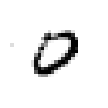

In [38]:
# convert same examples for testing
IMGNO = [3]
jsondata = {"image": test_images[IMGNO].reshape([HEIGHT,WIDTH]).tolist()}
json.dump(jsondata, codecs.open("../data/test_1.json", "w", encoding = "utf-8"))

plt.figure(figsize=(20,5))
i=0
for IMG in IMGNO:  
    i+=1
    plt.subplot(1, 10, i)
    plt.imshow(test_images[IMG].reshape(HEIGHT, WIDTH), cmap=plt.cm.binary)
    plt.axis('off')


## Local predict (Not working)

In [28]:
# this maybe a cloud sdk not supporting python 2.7 on windows..
!gcloud ai-platform local predict \
--model-dir=.\trained_test\export\1567026070\ \
--json-instances=test_1.json

If the signature defined in the model is not serving_default then you must specify it via --signature-name flag, otherwise the command may fail.
ERROR: (gcloud.ai-platform.local.predict) Something has gone really wrong; we can't find a valid Python executable on your PATH.


## Send data to the prediction service

In [25]:
MODEL_NAME='kaggle_digit_cnn'
MODEL_VERSION="t01"
JSON_DATA="../data/test_1.json"

In [39]:
!gcloud ai-platform predict \
    --model=$MODEL_NAME \
    --version=$MODEL_VERSION \
    --json-instances=$JSON_DATA

CLASS_IDS  PROBABILITIES
0          [0.7255470156669617, 0.000783188792411238, 0.045175887644290924, 0.0027230193372815847, 0.00012076550774509087, 0.0006411413196474314, 0.00045932986540719867, 0.013404745608568192, 0.022294849157333374, 0.1888500154018402]


<h2 id="Summary">Summary</h2>

<p>This is a basic flow for training, deploying model on GCP, and perform a prediction. it trains only 2 epochs and predict 1 image. finally run will be full strength.</p>

<p>&nbsp;</p>

<h2 id="Next-steps">Next steps</h2>

<ol>
	<li>batch prediction</li>
	<li>data augmentation with iterator</li>
	<li>replace&nbsp;tf.contrib.layers.optimize_loss&nbsp;since it will be deprecated in tf2.0, new method should also implement adaptive ir</li>
</ol>
